# Benue buffer exposure

In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [285]:
import ocha_stratus as stratus
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
from rioxarray.exceptions import NoDataInBounds

from src.datasources import codab, hydrosheds, worldpop
from src.constants import *

In [4]:
gdf_benue = hydrosheds.load_benue_aoi()

In [21]:
adm2 = codab.load_codab_from_blob(admin_level=2, aoi_only=True)
adm2 = adm2[adm2["ADM1_PCODE"] == ADAMAWA]

In [28]:
da_wp = worldpop.load_raw_worldpop()
da_wp.attrs["_FillValue"] = np.nan

In [105]:
da_wp_adm = da_wp.rio.clip(adm2.geometry)

In [106]:
da_wp_buffer = da_wp_adm.rio.clip(gdf_benue_buffer.geometry)

In [180]:
dicts = []
for buffer_km in [1, 5, 10, 20]:
    gdf_benue_buffer = (
        gdf_benue.to_crs(3857).buffer(buffer_km * 1000).to_crs(4326)
    )
    da_buffer = da_wp.rio.clip(gdf_benue_buffer.geometry)
    for pcode, row in adm2.set_index("ADM2_PCODE").iterrows():
        try:
            da_clip = da_buffer.rio.clip([row.geometry])
        except NoDataInBounds:
            continue
        pop = int(da_clip.sum())
        if pop < 1:
            continue
        dicts.append(
            {
                "ADM2_PCODE": pcode,
                "ADM2_EN": row["ADM2_EN"],
                "buffer_km": buffer_km,
                "pop": pop,
            }
        )

df_exp = pd.DataFrame(dicts)

df_exp = df_exp.pivot(
    index=["ADM2_PCODE", "ADM2_EN"], columns="buffer_km", values="pop"
)

df_exp.columns = [f"pop_{int(x)}km_buffer" for x in df_exp.columns]

df_exp = df_exp.reset_index()
df_exp = df_exp.fillna(0)
df_exp = df_exp.astype(int, errors="ignore")

In [181]:
df_exp.sum(numeric_only=True)

pop_1km_buffer      113813
pop_5km_buffer      621174
pop_10km_buffer    1090737
pop_20km_buffer    1396505
dtype: int64

In [183]:
df_exp

,ADM2_PCODE,ADM2_EN,pop_1km_buffer,pop_5km_buffer,pop_10km_buffer,pop_20km_buffer
0,NG002001,Demsa,6369,33914,51665,73447
1,NG002002,Fufore,22343,77203,145192,223624
2,NG002005,Girei,56479,125612,164914,208615
3,NG002006,Guyuk,0,0,0,8896
4,NG002009,Lamurde,10324,36409,73197,108555
5,NG002016,Numan,15766,88531,110746,130581
6,NG002017,Shelleng,0,0,0,26733
7,NG002018,Song,0,0,91,6027
8,NG002020,Yola North,2195,144863,234307,234307
9,NG002021,Yola South,337,114642,310625,375720


In [324]:
blob_name = f"{PROJECT_PREFIX}/processed/adamawa_benue_buffer_pop.csv"
stratus.upload_csv_to_blob(df_exp, blob_name)

In [281]:
def add_pop_density(da_pop):
    lat = da_pop["y"]
    area_km2 = xr.DataArray(
        111.32 * 0.01 * 111.32 * 0.01 * np.cos(np.deg2rad(lat)),
        coords={"y": lat},
        dims="y",
    )
    # Expand to 2D if needed
    area_2d = area_km2.broadcast_like(da_pop)
    da_density = da_pop / area_2d
    da_density.name = "population_density_km2"
    return da_density

In [282]:
da_density = add_pop_density(da_wp_adm)

Text(0.5, 1.0, 'Adamawa population distribution\nwith Benue river buffers at 1, 5, 10, 20 km')

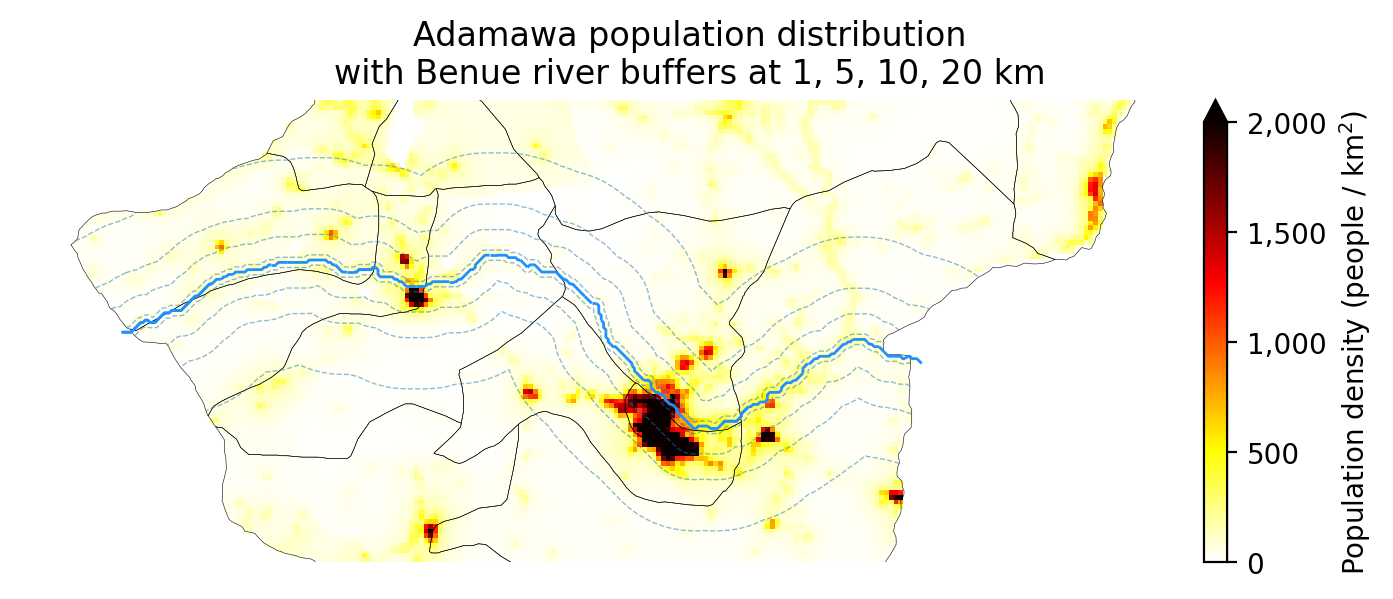

In [321]:
fig, ax = plt.subplots(dpi=200, figsize=(10, 3))
mappable = da_density.plot(
    cmap="hot_r", ax=ax, add_colorbar=False, vmin=0, vmax=2000
)

cbar = fig.colorbar(mappable, ax=ax, fraction=0.02, pad=-0.1, extend="max")
cbar.ax.yaxis.set_major_formatter(
    mticker.FuncFormatter(lambda x, _: f"{int(x):,}")
)
cbar.set_label("Population density (people / km$^2$)")
adm2.boundary.plot(linewidth=0.2, color="k", ax=ax)
gdf_benue.plot(linewidth=1, color="dodgerblue", ax=ax)
adm2_union = adm2.union_all()
buffer_kms = [1, 5, 10, 20]
for buffer_km in buffer_kms:
    # Create merged buffer around Benue
    buffer_geom = gdf_benue.to_crs(3857).buffer(buffer_km * 1000).union_all()
    buffer_geom = (
        gpd.GeoSeries([buffer_geom], crs=3857).to_crs(4326).union_all()
    )

    # Get the boundary line
    buffer_boundary = buffer_geom.boundary

    # Clip the boundary to only the part that intersects ADM2
    clipped_boundary = buffer_boundary.intersection(adm2_union)

    # Plot (only if not empty)
    if not clipped_boundary.is_empty:
        gpd.GeoSeries([clipped_boundary], crs=4326).plot(
            ax=ax, linewidth=0.5, linestyle="--", alpha=0.5
        )

ax.axis("off")
ax.set_ylim(top=9.8, bottom=9)
ax.set_title(
    "Adamawa population distribution\n"
    "with Benue river buffers at "
    f"{', '.join([str(x) for x in buffer_kms])} km"
)